In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from sklearn.metrics import mean_squared_error
from math import sqrt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\merti\AppData\Local\Programs\Python\Python311\Lib\runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\merti\AppData\Local\Programs\Python\Python311\Lib\runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "C:\Users\merti\PycharmProjects\bfh24\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\merti\PycharmProjects\bfh24\venv\Lib\site-packages\traitlets\config\application.py

AttributeError: _ARRAY_API not found

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception

In [8]:
# Set plot style
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'

# Load cleaned data
Data is preprocessed in the [data preprocessing](./create_dataset.ipynb) notebook. This includes concatenating the data, removing outliers, missing values, and irrelevant columns and generating relevant features based on given data.

In [9]:
data_per_day = pd.read_pickle('../data/processed/data_one_day_clean.pickle')

In [10]:
data_per_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Tank-ID                              3285 non-null   int64  
 1   Zeitstempel                          3285 non-null   object 
 2   Füllstand                            3285 non-null   float64
 3   Linear Prozentwert                   3285 non-null   float64
 4   Sensorwert                           3285 non-null   float64
 5   Leerstand                            3285 non-null   float64
 6   Maximale Füllgrenze                  3285 non-null   float64
 7   Temperatur                           3285 non-null   float64
 8   Sensorlage                           3285 non-null   float64
 9   Breitengrad                          3285 non-null   float64
 10  Längengrad                           3285 non-null   float64
 11  Sicherheitsbestand wird erreic

In [11]:
# convert date columns from object to datetime
date_cols = ['Zeitstempel', 'Sicherheitsbestand wird erreicht am', 'Meldebestand wird erreicht am']
for col in date_cols:
    data_per_day[col] = pd.to_datetime(data_per_day[col])

In [12]:
data_per_day.head()

,Tank-ID,Zeitstempel,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,Breitengrad,Längengrad,Sicherheitsbestand wird erreicht am,Meldebestand wird erreicht am,Verbrauch,Verbrauch smoothed
0,0,2022-10-11,3165.0,32.0,1.48,6835.0,10000.0,21.0,4.0,48.291924,8.072995,2026-05-15,2025-06-26,-13.0,-5.909091
1,0,2022-10-12,3152.0,32.0,1.48,6839.0,10000.0,20.0,3.0,48.291924,8.072995,2026-05-15,2025-06-26,0.0,-5.636364
2,0,2022-10-13,3152.0,32.0,1.48,6848.0,10000.0,20.0,3.0,48.291924,8.072995,2026-05-15,2025-06-26,-4.0,-5.454545
3,0,2022-10-14,3148.0,31.0,1.48,6848.0,10000.0,20.0,3.0,48.291924,8.072995,2026-05-15,2025-06-26,-8.0,-5.590909
4,0,2022-10-15,3140.0,31.0,1.49,6857.0,10000.0,20.0,3.0,48.291924,8.072995,2026-05-15,2025-06-26,-3.0,-6.045455


# Build target variable "Verbrauch" per day
Difference of the "Füllstand" the current day to the next day. This is the oil consumption per day. Implementation also see [data preprocessing](./create_dataset.ipynb), calculate "Füllstand" difference from day before to current day, then shift by one day to the past, since this difference is the consumption of the day before.

In [13]:
#!IMPORTANT! Shift the consumption by one day to the future, since on day x the "Füllstand" of day x+1 is not known, necessary for calculating the consumption of day x
for id in data_per_day["Tank-ID"].unique():
    temp_df = pd.DataFrame(data_per_day[data_per_day["Tank-ID"] == id])
    temp_df["Verbrauch"] = temp_df["Füllstand"].diff()

# Concat matching historical weather data
We implemented a wrapper to gain historical and forecast weather data per day using an open source API, see in [weather data](../src/api/weather.py) notebook. This then can be easily concatenated as an external feature to the data.

In [14]:
from src.api import WeatherAPI

weather_api = WeatherAPI()

merged_dfs = []
for id in data_per_day["Tank-ID"].unique():
    temp_df = data_per_day[data_per_day["Tank-ID"] == id]

    # get attributes
    latitude = temp_df["Längengrad"].iloc[0]
    longitude = temp_df["Breitengrad"].iloc[0]
    if temp_df["Zeitstempel"].dtypes == 'object':
        temp_df["Zeitstempel"] = pd.to_datetime(temp_df["Zeitstempel"])
    start_date = temp_df["Zeitstempel"].min().strftime("%Y-%m-%d")
    end_date = temp_df["Zeitstempel"].max().strftime("%Y-%m-%d")
    print("Start date:", start_date, "End date:", end_date, "Day difference:", (temp_df["Zeitstempel"].max() - temp_df["Zeitstempel"].min()).days)

    # get matching weather data
    weather_data = weather_api.get_data(latitude, longitude, start_date, end_date)

    # remove timezone information
    weather_data['date'] = weather_data['date'].dt.tz_localize(None)
    weather_data = weather_data.rename(columns={'date': 'Zeitstempel'})

    # join
    print("Data shape before merge:", temp_df.shape)
    temp_df = temp_df.merge(weather_data, on=['Zeitstempel'], how='left')
    print("Data shape after merge:", temp_df.shape)
    display(temp_df.head(5))

    # append
    merged_dfs.append(temp_df)

Start date: 2022-10-11 End date: 2024-10-10 Day difference: 730
Data shape before merge: (720, 15)
Data shape after merge: (720, 25)


,Tank-ID,Zeitstempel,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,Breitengrad,...,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum
0,0,2022-10-11,3165.0,32.0,1.48,6835.0,10000.0,21.0,4.0,48.291924,...,30.319500,20.669500,25.269503,31.575672,21.464046,25.863174,39600.000000,0.5,0.5,0.0
1,0,2022-10-12,3152.0,32.0,1.48,6839.0,10000.0,20.0,3.0,48.291924,...,32.119499,20.369501,25.671583,32.531101,20.440941,25.363289,39600.000000,0.2,0.2,0.0
2,0,2022-10-13,3152.0,32.0,1.48,6848.0,10000.0,20.0,3.0,48.291924,...,32.469501,19.669500,25.825750,32.096367,20.117737,25.493662,39600.000000,0.0,0.0,0.0
3,0,2022-10-14,3148.0,31.0,1.48,6848.0,10000.0,20.0,3.0,48.291924,...,30.269501,20.319500,24.621584,30.836559,20.033968,24.405569,37589.289062,0.6,0.6,0.0
4,0,2022-10-15,3140.0,31.0,1.49,6857.0,10000.0,20.0,3.0,48.291924,...,30.869501,19.969501,24.769499,32.056335,20.193466,25.130819,37727.843750,0.7,0.7,0.0


Start date: 2022-10-11 End date: 2024-10-10 Day difference: 730
Data shape before merge: (730, 15)
Data shape after merge: (730, 25)


,Tank-ID,Zeitstempel,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,Breitengrad,...,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum
0,1,2022-10-11,3312.0,75.0,0.56,1087.0,4400.0,14.0,3.0,48.349883,...,31.063000,21.963001,26.433832,32.243607,21.953514,27.124947,39600.0,0.6,0.6,0.0
1,1,2022-10-12,3310.0,75.0,0.56,1089.0,4400.0,15.0,3.0,48.349883,...,32.963001,21.513000,27.088003,33.577015,20.809103,26.772535,39600.0,0.0,0.0,0.0
2,1,2022-10-13,3308.0,75.0,0.56,1091.0,4400.0,15.0,3.0,48.349883,...,33.663002,21.013000,27.456749,33.389256,19.985128,26.396067,39600.0,0.0,0.0,0.0
3,1,2022-10-14,3305.0,75.0,0.56,1092.0,4400.0,15.0,3.0,48.349883,...,31.963001,21.363001,26.410919,32.309834,19.821192,25.217031,39600.0,0.0,0.0,0.0
4,1,2022-10-15,3302.0,75.0,0.56,1096.0,4400.0,15.0,3.0,48.349883,...,31.813000,20.963001,26.335917,34.287060,20.084286,26.547281,39600.0,0.3,0.3,0.0


Start date: 2022-10-11 End date: 2024-10-10 Day difference: 730
Data shape before merge: (725, 15)
Data shape after merge: (725, 25)


,Tank-ID,Zeitstempel,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,Breitengrad,...,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum
0,2,2022-10-11,3752.0,63.0,0.65,2248.0,6000.0,17.0,0.0,48.28,...,29.737000,20.737,25.220329,31.037769,21.383636,25.608675,39600.000000,0.8,0.8,0.0
1,2,2022-10-12,3752.0,63.0,0.65,2248.0,6000.0,17.0,0.0,48.28,...,32.036999,20.337,25.805748,32.316452,19.993282,25.185534,39600.000000,0.1,0.1,0.0
2,2,2022-10-13,3752.0,63.0,0.65,2248.0,6000.0,17.0,0.0,48.28,...,32.437000,19.687,25.982834,32.123798,19.733767,25.315840,39600.000000,0.0,0.0,0.0
3,2,2022-10-14,3752.0,63.0,0.65,2248.0,6000.0,17.0,0.0,48.28,...,30.087000,20.337,24.743250,30.479107,19.603529,24.168177,38418.027344,0.4,0.4,0.0
4,2,2022-10-15,3744.0,62.0,0.65,2256.0,6000.0,17.0,0.0,48.28,...,30.536999,19.987,24.797417,31.296822,19.737906,24.804525,39600.000000,0.5,0.5,0.0


Start date: 2023-01-06 End date: 2024-10-10 Day difference: 643
Data shape before merge: (643, 15)
Data shape after merge: (643, 25)


,Tank-ID,Zeitstempel,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,Breitengrad,...,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum
0,3,2023-01-06,3633.0,81.0,0.89,865.23,4500.0,16.0,0.0,48.2912,...,27.950500,16.450500,22.019249,26.848169,16.780895,21.387306,37336.171875,0.0,0.0,0.0
1,3,2023-01-07,3370.0,75.0,0.90,1128.00,4500.0,16.0,1.0,48.2912,...,28.900499,17.800501,22.756752,27.724695,18.046074,22.214468,33149.058594,0.0,0.0,0.0
2,3,2023-01-08,3359.0,75.0,0.90,1137.00,4500.0,16.0,1.0,48.2912,...,28.900499,17.400499,22.773415,27.509556,17.445536,21.776693,31372.746094,0.0,0.0,0.0
3,3,2023-01-09,3345.0,74.0,0.90,1151.00,4500.0,16.0,1.0,48.2912,...,29.650499,17.850500,23.090086,28.272625,17.993799,22.329760,38126.796875,0.0,0.0,0.0
4,3,2023-01-10,3333.0,74.0,0.90,1165.00,4500.0,16.0,1.0,48.2912,...,29.050501,16.550501,22.444254,27.667995,16.806328,21.624128,37053.281250,0.0,0.0,0.0


Start date: 2023-12-14 End date: 2024-10-10 Day difference: 301
Data shape before merge: (302, 15)
Data shape after merge: (302, 25)


,Tank-ID,Zeitstempel,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,Breitengrad,...,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum
0,4,2023-12-14,4615.0,77.0,0.33,1339.0,6000.0,12.0,1.0,48.291074,...,30.850500,17.650499,24.698416,30.242401,18.681931,24.640366,38766.890625,0.0,0.0,0.0
1,4,2023-12-15,4650.0,77.0,0.34,1350.0,6000.0,12.0,1.0,48.291074,...,32.100498,19.050501,25.306749,28.945107,19.701454,22.979879,38734.339844,0.0,0.0,0.0
2,4,2023-12-16,4639.0,77.0,0.34,1361.0,6000.0,12.0,1.0,48.291074,...,30.500500,20.350500,24.788002,26.088270,19.163254,21.780479,35814.343750,0.0,0.0,0.0
3,4,2023-12-17,4623.0,77.0,0.34,1377.0,6000.0,12.0,1.0,48.291074,...,30.250500,18.450500,23.921333,26.392639,17.366495,21.113970,38669.960938,0.0,0.0,0.0
4,4,2023-12-18,4611.0,77.0,0.35,1389.0,6000.0,11.0,1.0,48.291074,...,29.750500,17.450500,23.752581,26.728495,16.044624,21.766806,38638.320312,0.0,0.0,0.0


Start date: 2024-04-26 End date: 2024-10-08 Day difference: 165
Data shape before merge: (165, 15)
Data shape after merge: (165, 25)


,Tank-ID,Zeitstempel,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,Breitengrad,...,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum
0,5,2024-04-26,1705.0,53.0,0.78,1489.0,3200.0,12.0,1.0,48.257439,...,33.874500,22.274500,26.891169,36.203896,23.833645,28.469858,28800.000000,0.4,0.4,0.0
1,5,2024-04-27,1709.0,53.0,0.78,1491.0,3200.0,12.0,1.0,48.257439,...,33.874500,22.874498,28.270332,36.019466,22.858801,29.538153,41559.132812,0.4,0.4,0.0
2,5,2024-04-28,1709.0,53.0,0.78,1491.0,3200.0,13.0,1.0,48.257439,...,32.574501,23.174500,27.293243,35.969776,25.417713,29.495810,41077.742188,1.2,1.2,0.0
3,5,2024-04-29,1709.0,53.0,0.78,1491.0,3200.0,13.0,1.0,48.257439,...,31.524500,21.974499,26.634912,35.299961,24.014767,29.219803,32400.000000,1.2,1.2,0.0
4,5,2024-04-30,1709.0,53.0,0.78,1491.0,3200.0,14.0,1.0,48.257439,...,31.024500,22.074499,24.991167,35.356888,25.113462,28.575663,38394.062500,15.5,15.5,0.0


In [15]:
merged_data = pd.concat(merged_dfs)

In [16]:
print("Data shape before merging weatehr data:", data_per_day.shape)
print("Data shape after merging weather data:", merged_data.shape)

Data shape before merging weatehr data: (3285, 15)
Data shape after merging weather data: (3285, 25)


In [17]:
# set index to "Zeitstempel"
df = merged_data.set_index('Zeitstempel')

# Investigate data

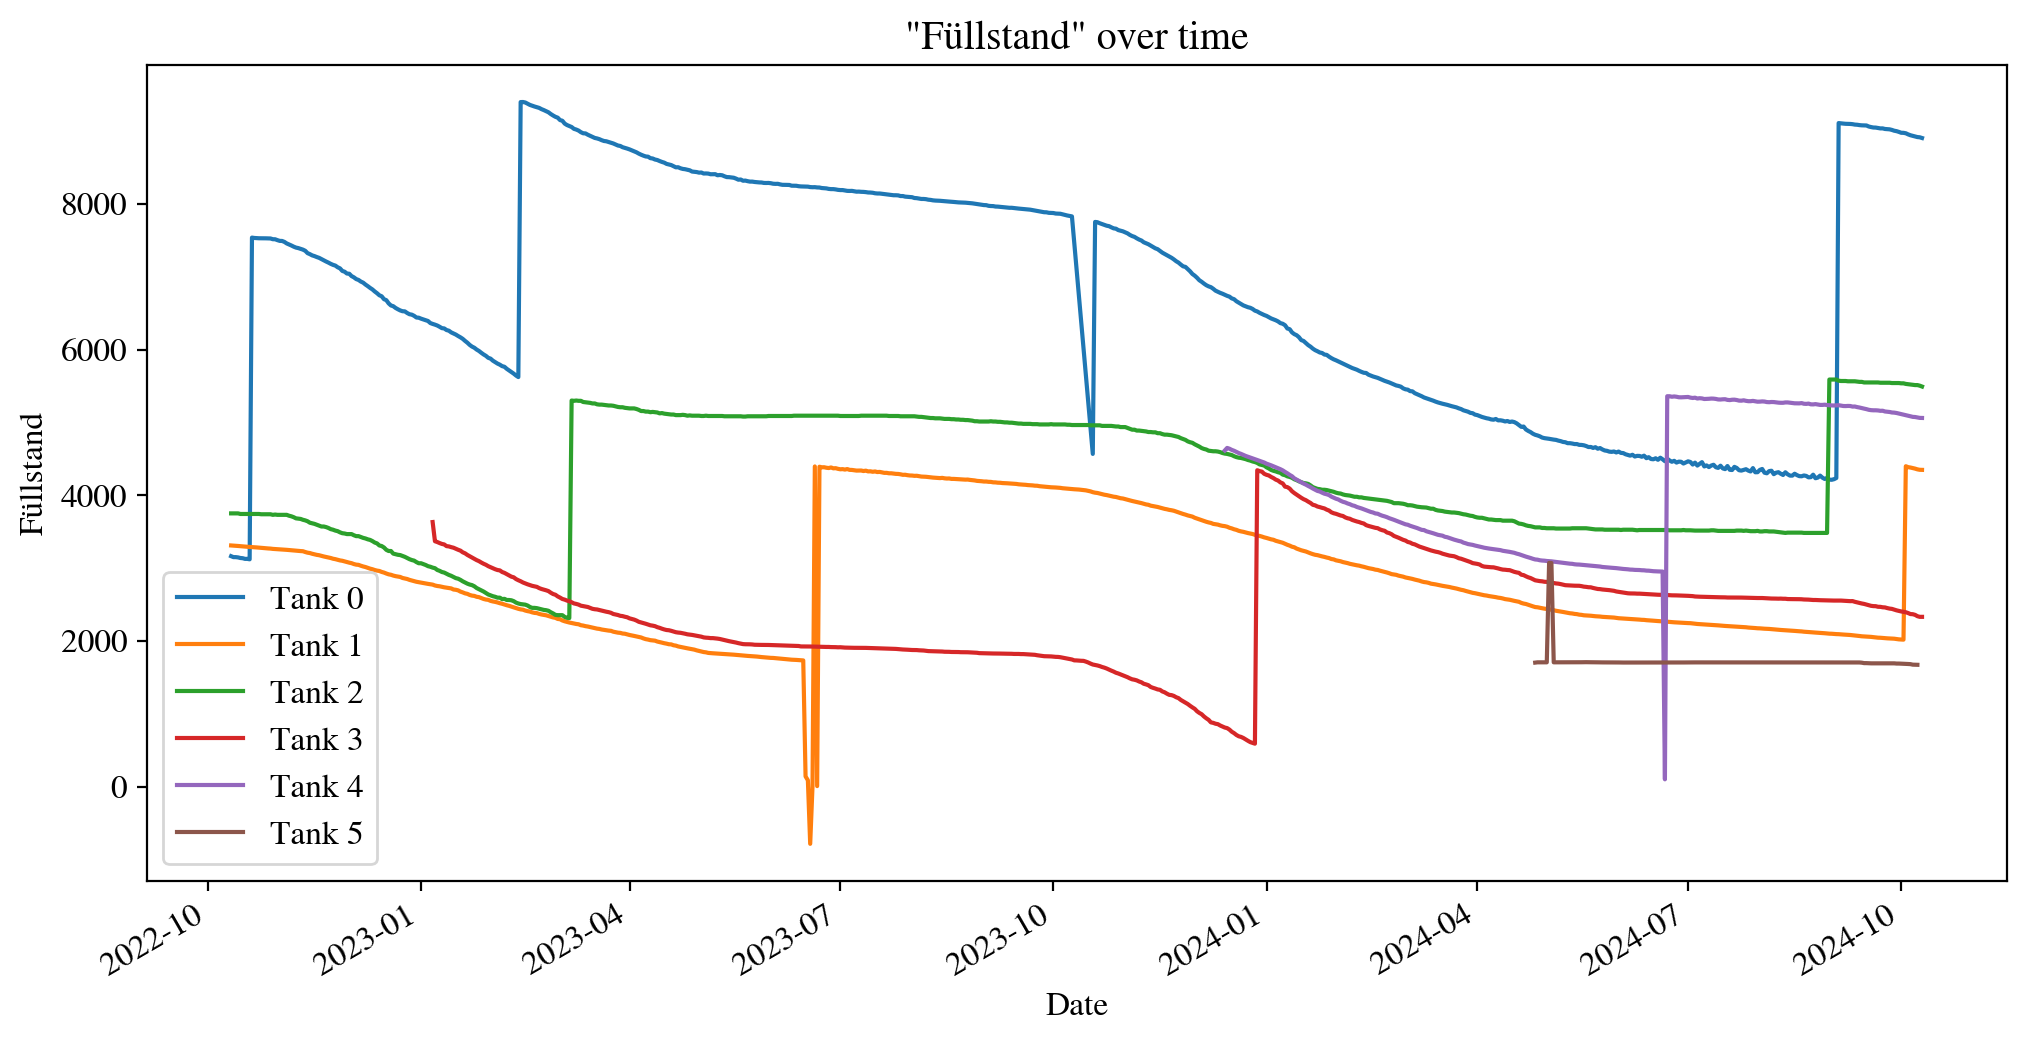

In [18]:
# plot "Füllstand" time series based on tank ID
fig, ax = plt.subplots(figsize=(12, 6))
for tank_id in df["Tank-ID"].unique():
    df[df["Tank-ID"] == tank_id]["Füllstand"].plot(ax=ax, label=f'Tank {tank_id}')
plt.xlabel('Date')
plt.ylabel('Füllstand')
plt.title('"Füllstand" over time')
plt.legend()
plt.show()

Since the Tank ID 5 has a different pattern than the other tanks, and the data is not complete, we will drop this tank.

In [19]:
# drop irrelevant columns
cols_to_drop = ["Sicherheitsbestand wird erreicht am", "Meldebestand wird erreicht am"] # "Füllstand"
df = df.drop(cols_to_drop, axis=1)
# drop ID 5
df = df[df['Tank-ID'] != 5]

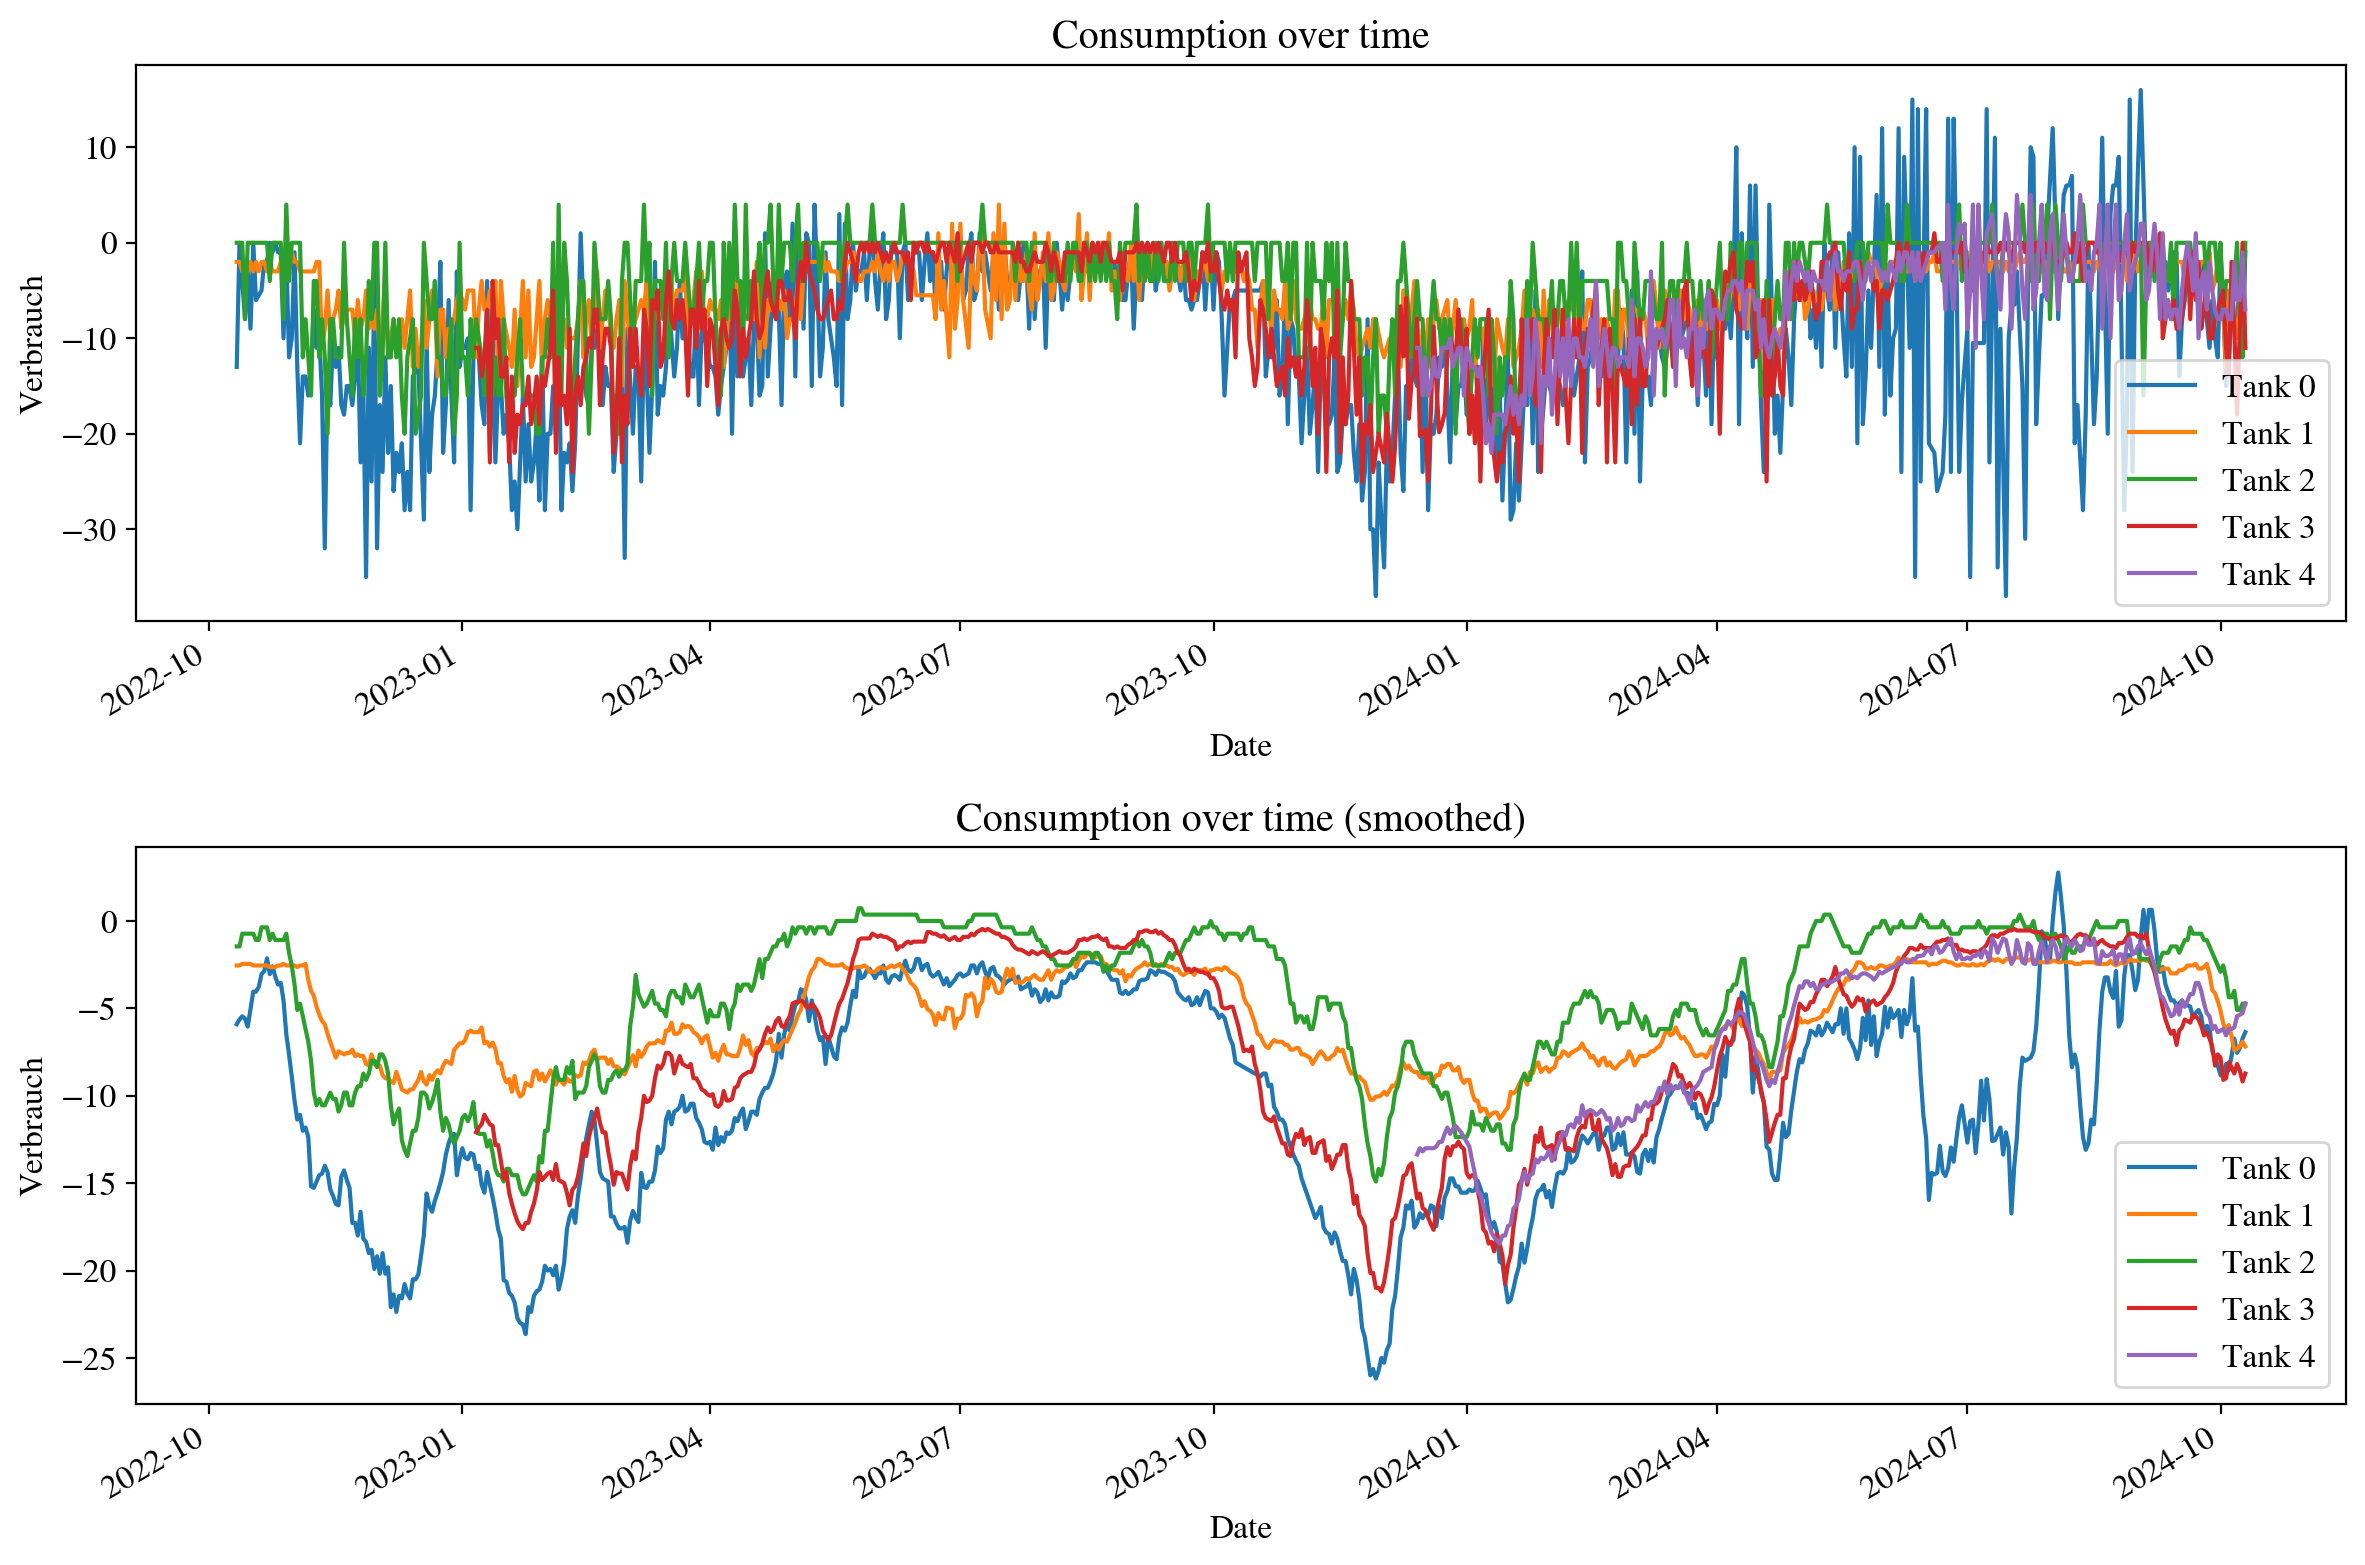

In [20]:
# plot target "Verbrauch" time series based on tank ID
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
for tank_id in df["Tank-ID"].unique():
    df[df["Tank-ID"] == tank_id]["Verbrauch"].plot(ax=axes[0], label=f'Tank {tank_id}')
    df[df["Tank-ID"] == tank_id]["Verbrauch smoothed"].plot(ax=axes[1], label=f'Tank {tank_id}')

axes[0].set_title('Consumption over time')
axes[1].set_title('Consumption over time (smoothed)')

for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel('Verbrauch')
    ax.legend()

plt.tight_layout()
plt.show()

Since outliers above 0 make no sense and also in our implemented smoothing functionality it is detected as outliers we will set a maximum value of 0 for the consumption. Logically also one can not consume oil and the tank gets filled up by consuming it. This is a clear indicator for a wrong measurement. In the plot above we can see that the consumption is mostly below 0, where a value of -10 indicates a consumption of 10 liters, the negative sign is due to the resulting decline in the tank by consumption. Thus the 0 value indicates a full no consumption and thus no decline in the tank. For better understanding we will further take the absolute value of the consumption. after correcting the outliers due to sensor errors.
--> 1. Set consumption to 0 if above 0
--> 2. Take absolute values

In [21]:
# correct outliers
df.loc[df['Verbrauch'] > 0, 'Verbrauch'] = 0.0
# take absolute values
df['Verbrauch'] = df['Verbrauch'].abs()
# drop NaN values
df = df.dropna()

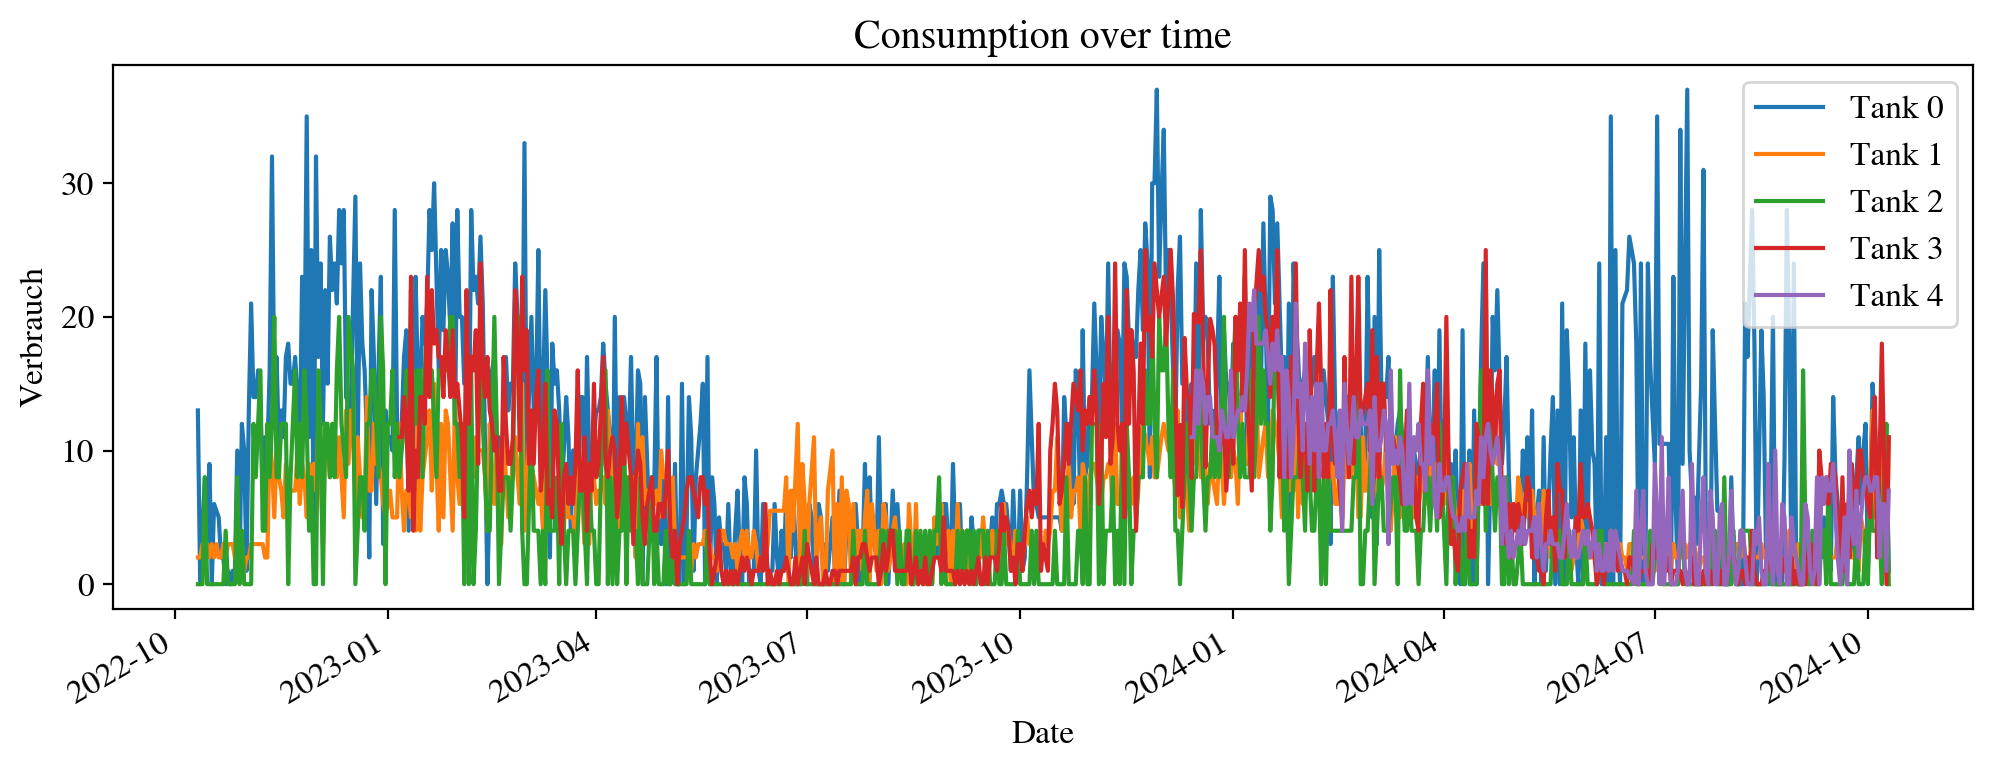

In [22]:
# check if outliers are corrected
fig, ax = plt.subplots(figsize=(12, 4))
for tank_id in df["Tank-ID"].unique():
    df[df["Tank-ID"] == tank_id]["Verbrauch"].plot(ax=ax, label=f'Tank {tank_id}')
plt.xlabel('Date')
plt.ylabel('Verbrauch')
plt.title('Consumption over time')
plt.legend()
plt.show()

# Prepare Train and Test Data

In [23]:
# split data into train and test data, based on tank ID
train_data = df[df['Tank-ID'] != 2]
train_data = {tank_id: train_data[train_data['Tank-ID'] == tank_id] for tank_id in train_data['Tank-ID'].unique().tolist()}
test_data = df[df['Tank-ID'] == 2]

In [24]:
# get column names in correct order
col_names = train_data[0].columns.tolist()

In [25]:
# get x and y values for each data set
X_train = {tank_id: train_data[tank_id].drop('Verbrauch', axis=1).values for tank_id in train_data.keys()}
y_train = {tank_id: train_data[tank_id]['Verbrauch'].values for tank_id in train_data.keys()}

X_test = test_data.drop('Verbrauch', axis=1).values
y_test = test_data['Verbrauch'].values

In [26]:
# save data
for id in train_data.keys():
    np.save(f'../data/processed/X_train_{id}.npy', X_train[id])
    np.save(f'../data/processed/y_train_{id}.npy', y_train[id])
np.save('../data/processed/X_test.npy', X_test)
np.save('../data/processed/y_test.npy', y_test)

In [27]:
# normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for id in train_data.keys():
    X_train[id] = scaler.fit_transform(X_train[id])
X_test = scaler.transform(X_test)

In [28]:
print("X_train tank 0 shape:", X_train[0].shape)
print("y_train tank 0 shape:", y_train[0].shape)
print("X_train tank 1 shape:", X_train[1].shape)
print("y_train tank 1 shape:", y_train[1].shape)
print("X_train tank 3 shape:", X_train[3].shape)
print("y_train tank 3 shape:", y_train[3].shape)
print("X_train tank 4 shape:", X_train[4].shape)
print("y_train tank 4 shape:", y_train[4].shape)
print("="*50)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train tank 0 shape: (720, 21)
y_train tank 0 shape: (720,)
X_train tank 1 shape: (730, 21)
y_train tank 1 shape: (730,)
X_train tank 3 shape: (643, 21)
y_train tank 3 shape: (643,)
X_train tank 4 shape: (302, 21)
y_train tank 4 shape: (302,)
X_test shape: (725, 21)
y_test shape: (725,)


# Feature Selection
* via correlation
* via feature importance


In [29]:
SELECTED_ID = 1
X_train_selected = X_train[SELECTED_ID]
y_train_selected = y_train[SELECTED_ID]

## Option 1: ARIMA model


Reasoning:
* As seen in the plot of the target variable "Verbrauch" over time above, we can see that the oil consumption has a clear trend and seasonality:
* Peaks in winter (high consumption for heating), dips in summer (lower demand), and rises again in autumn. The pattern is cyclical, reflecting higher oil use in colder months and lower in warmer months.

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

--> This is a good indicator for using an ARIMA model.

In [30]:
# Check via ADF test if time series is stationary
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [31]:
check_stationarity(y_train_selected)

ADF Statistic: -2.756297
p-value: 0.064793
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


* The p-value is above 0.05
* The ADF statistic is only higher than the 1% and 5% critical values
--> Null hypothesis cannot be rejected for either 1% or 5% significance level, indicating that the time series is not stationary, and differencing is required.

## Model Initialization

In [32]:
# Plotting autocorrelation for an extensive set of time series lags (up to 30 lags, considering different IDs)
from pandas.plotting import autocorrelation_plot

def plot_autocorr_by_id(df, lags=30):
    plt.figure(figsize=(15, 6))

    # loop over each unique ID and plot autocorrelation for each
    for id in df['Tank-ID'].unique():
        subset = df[df['Tank-ID'] == id]

        autocorrelation_plot(subset['Verbrauch'], label=f'ID {id}')

    plt.title('Autocorrelation for Different IDs')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.legend(title='ID')
    plt.grid(True)
    plt.show()

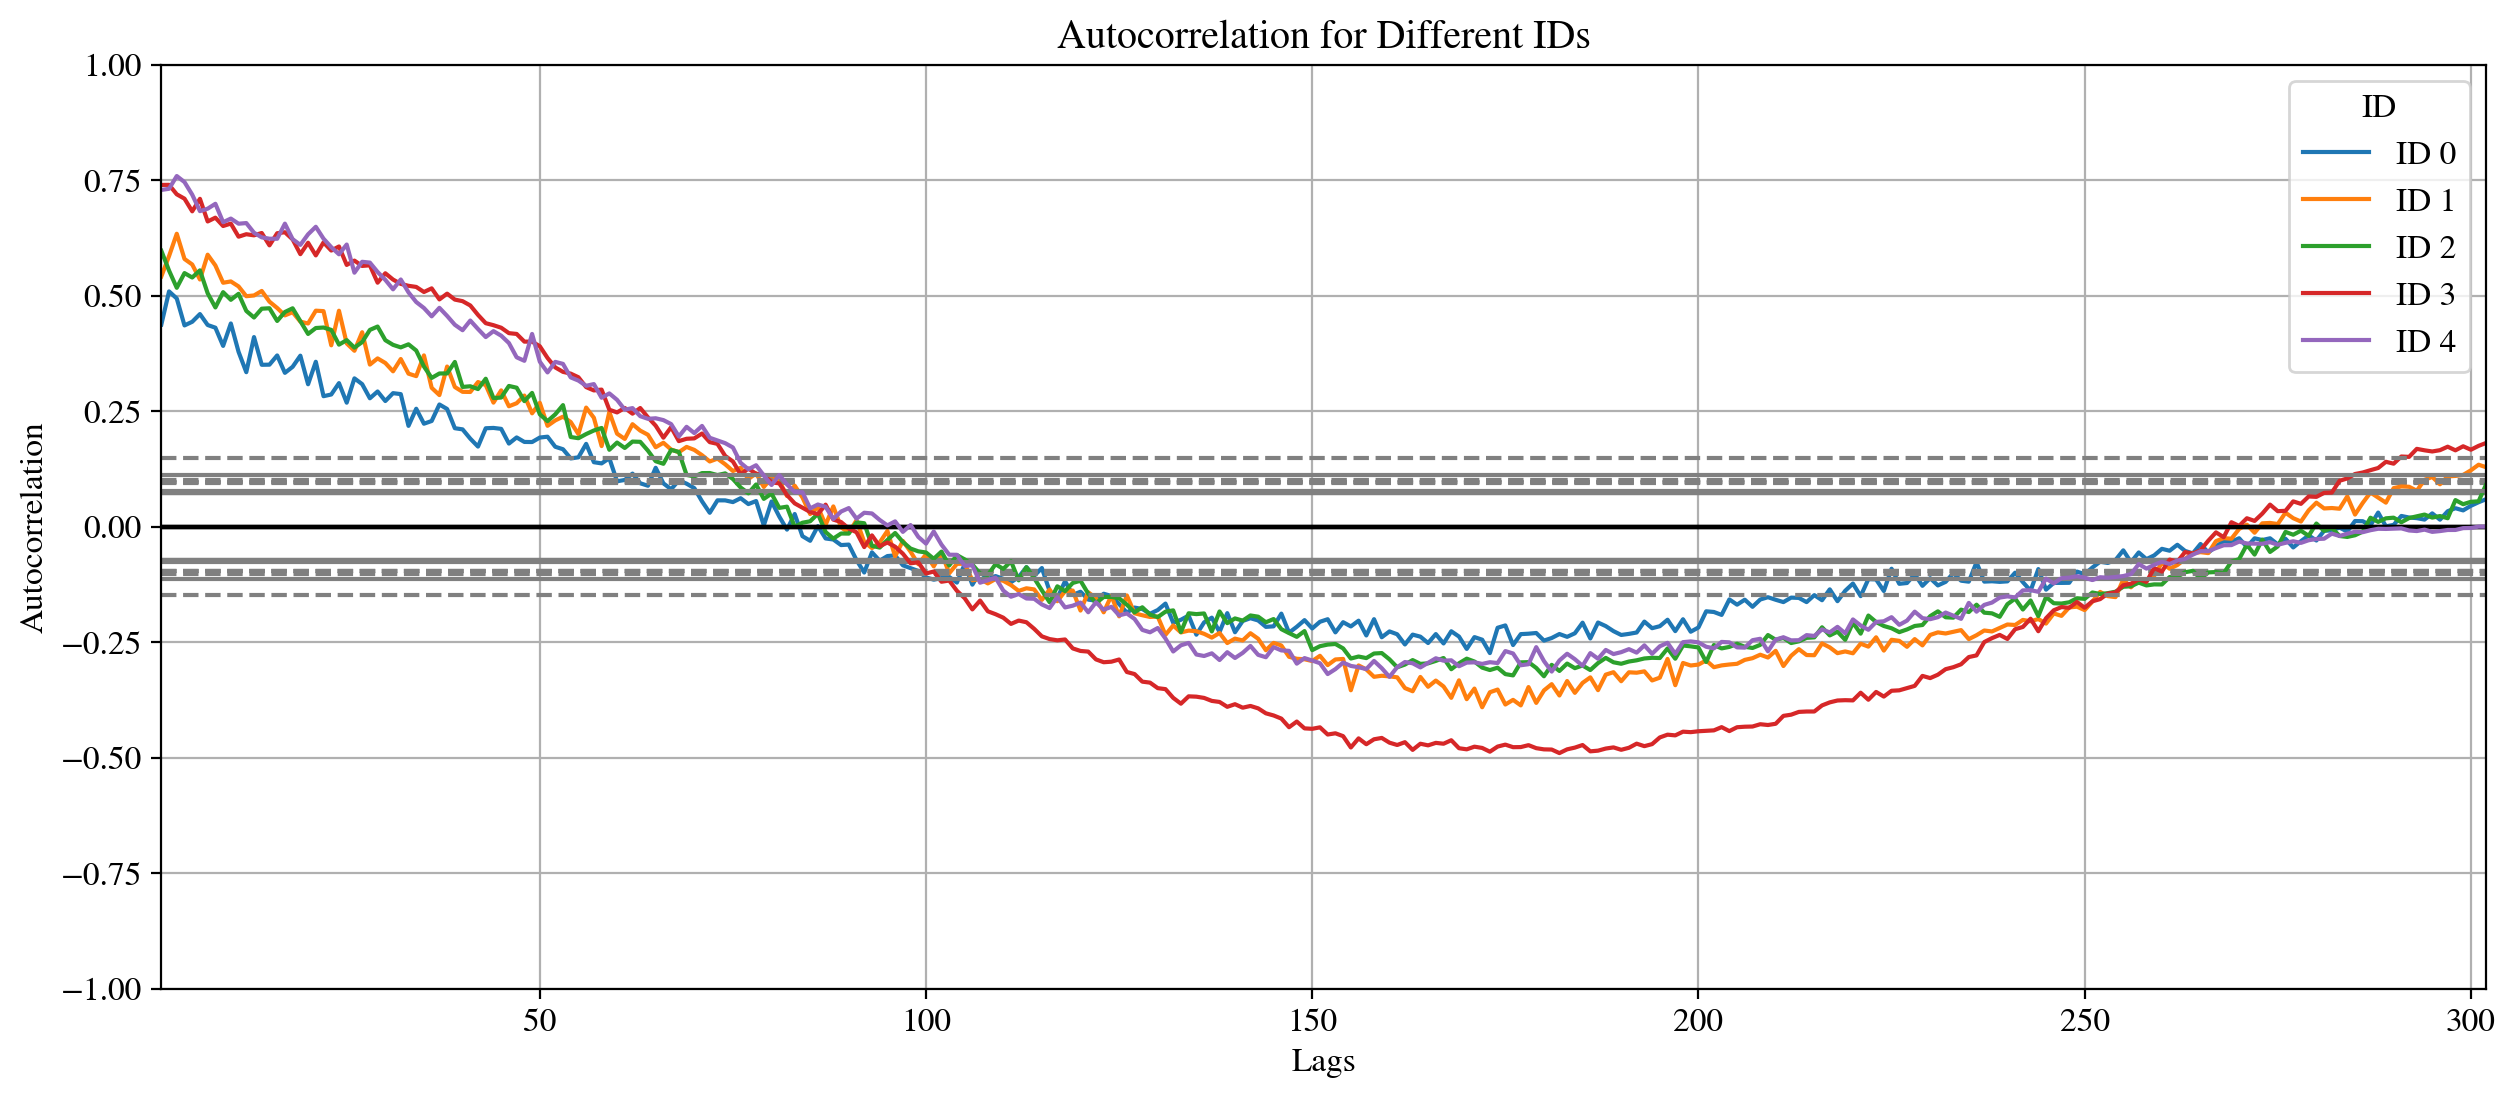

In [33]:
plot_autocorr_by_id(df, lags=30)

Findings:
* High autocorrelation at low lags: Oil consumption is correlated with recent past values, indicating trends or seasonality, which ARIMA can capture.
* Gradual decline: Autocorrelation decreases over time, showing diminishing influence of past values.
* Seasonality/Long-term Trends:
    * Negative autocorrelation at intermediate lags (100–200): Indicates potential seasonal cycles.
    * Return to positive autocorrelation (250–300 lags): Suggests long-term cycles or trends.

In [34]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(y_train_selected, order=(2,1,1))
model_fit = model.fit()

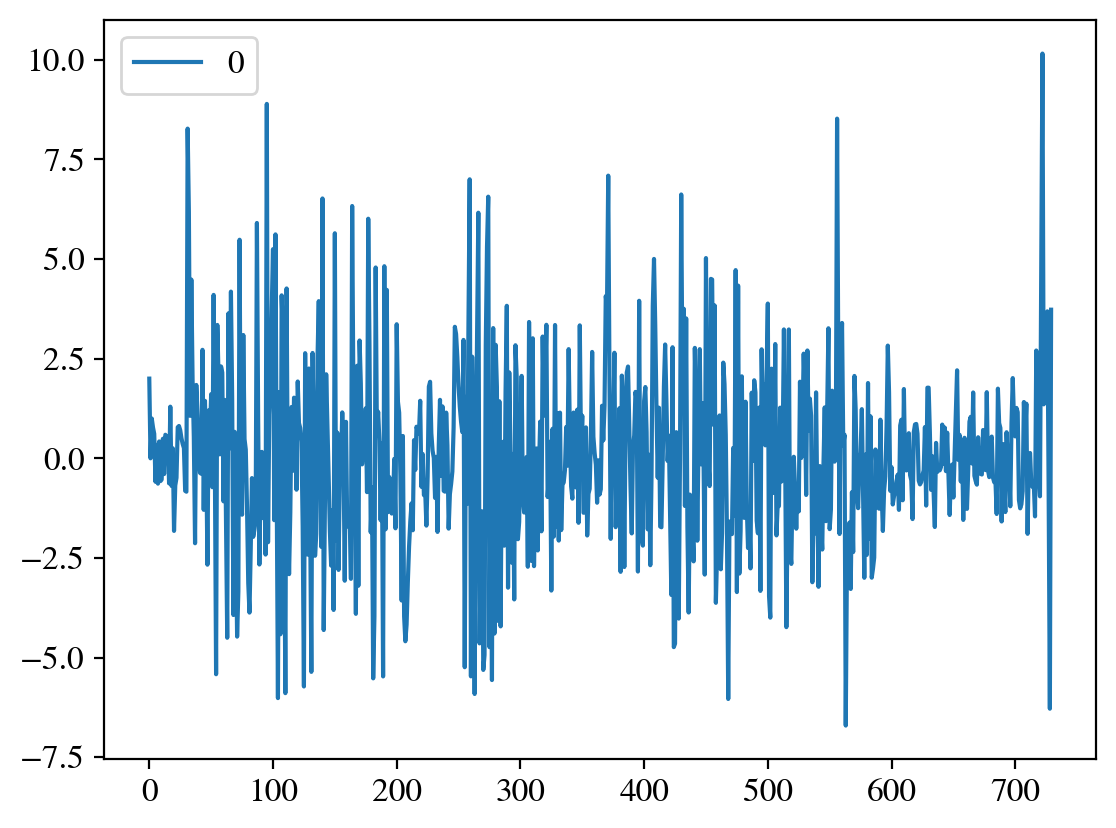

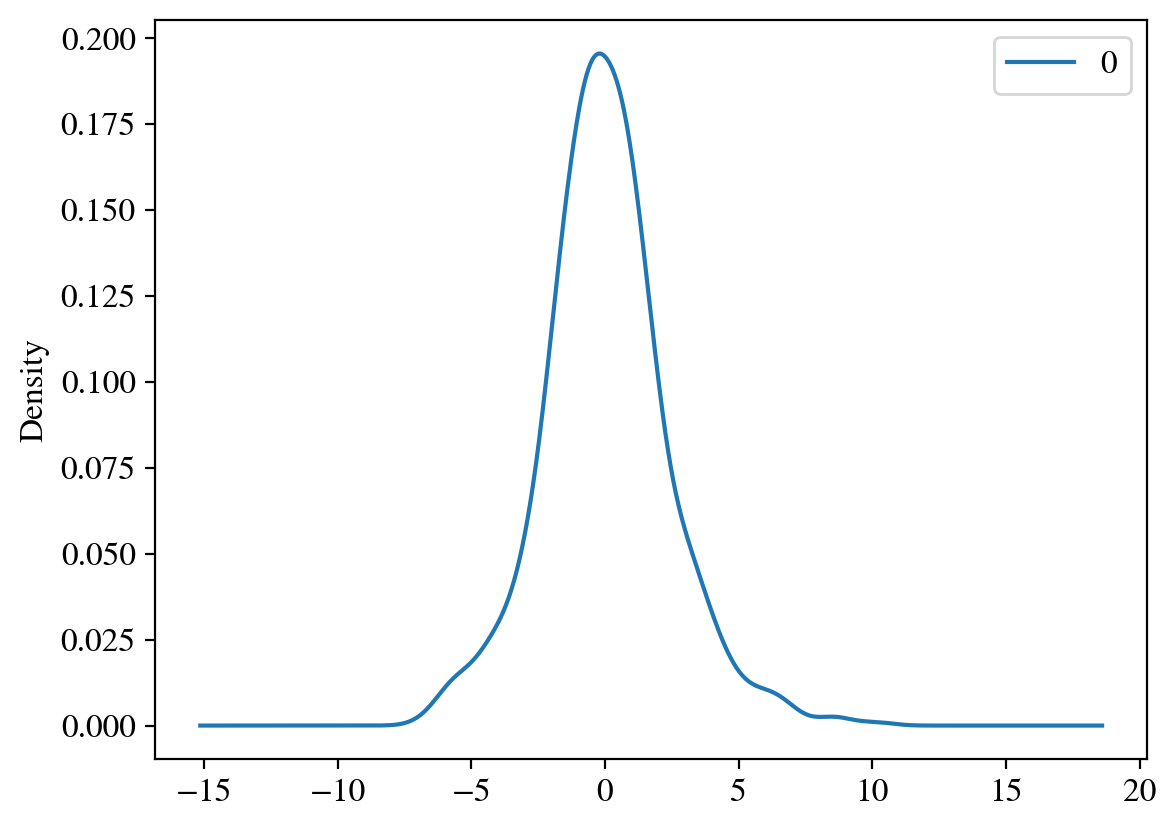

                0
count  730.000000
mean     0.032982
std      2.322061
min     -6.706873
25%     -1.351663
50%     -0.064115
75%      1.271013
max     10.157919


In [35]:
# plot residual errors (any trends?)
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# plot density (gaussian around zero?)
residuals.plot(kind='kde')
plt.show()
# mean of residuals (close to zero?)
print(residuals.describe())

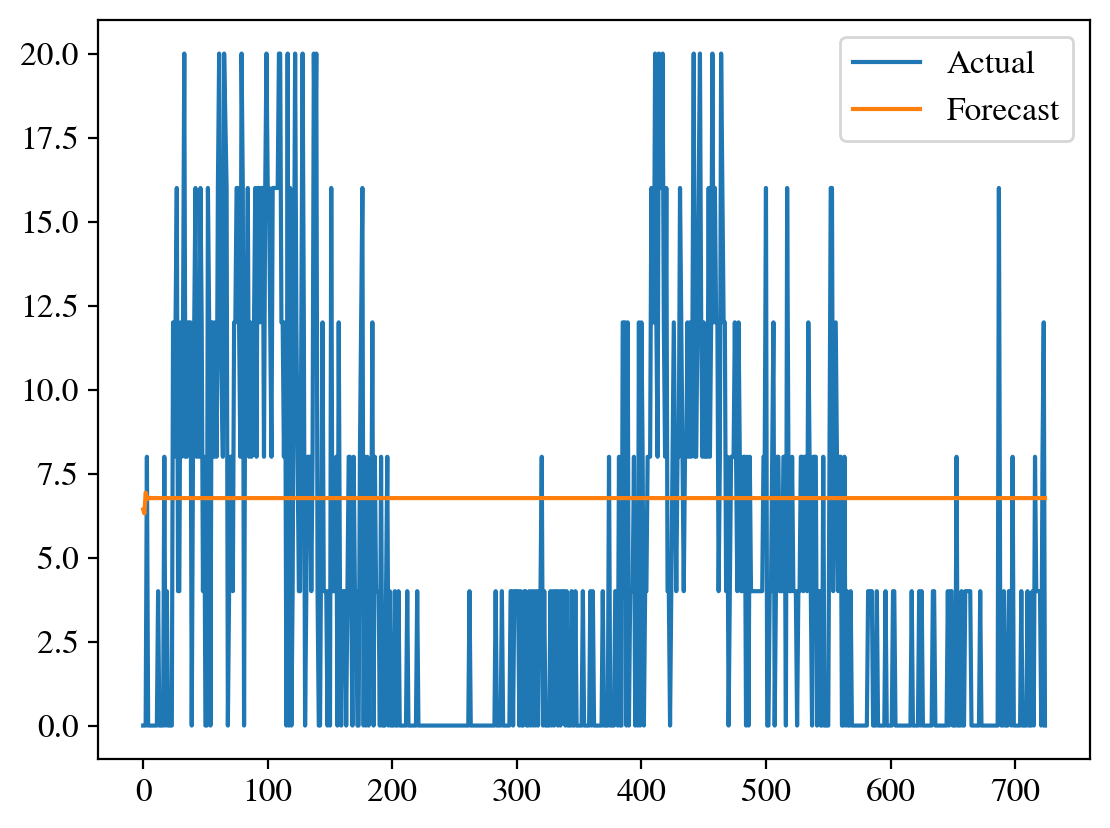

In [36]:
# forecast
forecast = model_fit.forecast(steps=len(y_test))
# plot difference between forecast and actual values
plt.plot(y_test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

## Option 2: LSTM model

In [37]:
past_steps = 10  # number of past days to consider (adjustable)
future_steps = 1  # number of future days to predict (adjustable)

In [38]:
def create_sequences(X, y, past_steps, future_steps):
    X_seqs, y_seqs = [], []
    for i in range(len(X) - past_steps - future_steps + 1):
        X_seqs.append(X[i:i + past_steps])  # Past steps of features
        y_seqs.append(y[i + past_steps:i + past_steps + future_steps])  # Future target(s)
    return np.array(X_seqs), np.array(y_seqs)

In [39]:
X_seq, y_seq = create_sequences(X_train_selected, y_train_selected, past_steps, future_steps)
# check the shapes of the created sequences
print(f"X_seq shape: {X_seq.shape}")  # (samples, past_steps, num_features)
print(f"y_seq shape: {y_seq.shape}")  # (samples, future_steps)

X_seq shape: (720, 10, 21)
y_seq shape: (720, 1)


In [40]:
# split data into training and validation sets
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [41]:
# init lstm
model = keras.Sequential()
model.add(layers.LSTM(50, activation='relu', input_shape=(past_steps, X_train_seq.shape[2])))
model.add(layers.Dense(future_steps))
model.compile(optimizer='adam', loss='mse')

NameError: name 'keras' is not defined

In [ ]:
# fit
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_val_seq, y_val_seq), verbose=1)

In [42]:
# evaluate history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [43]:
# predict
y_pred = model.predict(X_val_seq)

rmse = sqrt(mean_squared_error(y_val_seq, y_pred))
print(f'RMSE: {rmse}')

NotImplementedError: 

NameError: name 'y_pred' is not defined

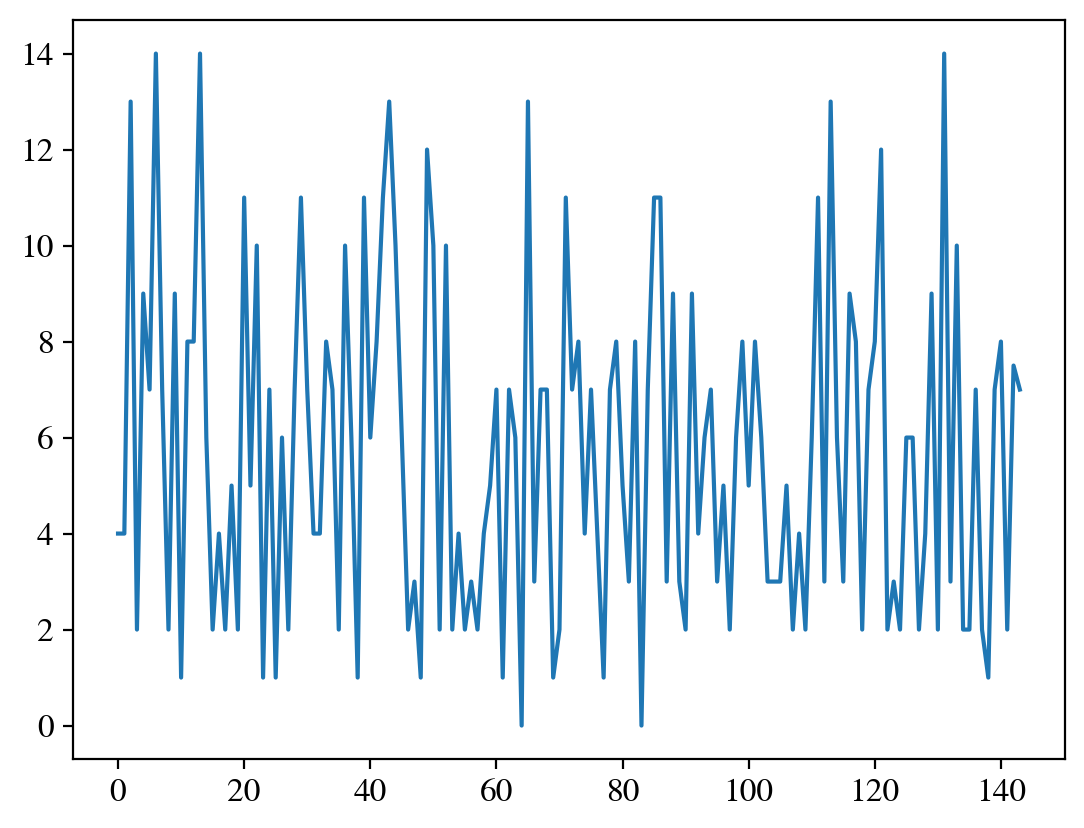

In [44]:
# plot actual vs. predicted values
plt.plot(y_val_seq, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.suptitle('Actual vs. Predicted Consumption')
plt.legend()
plt.show()

ent# Reccommendation


In [47]:
today = pd.Timestamp.now().date()
